In [85]:
# start analysis here


import os
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time
from shapely.geometry import Point
from geopy.distance import geodesic
from matplotlib.lines import Line2D

# files saved under Data/ActiveTravelCounts
dir = 'dataset/'

counts_df = pd.read_parquet(os.path.join(dir, 'counts_cleaned.parquet'))

In [86]:
counts_df.sample(5)

,Year,UnqID,Zone,datetime,Date,Weather,Time,Day,Round,Dir,Path,Mode,Count,isdry,ispeak,isCarriageway,isPavement,isCycle,isBus,isShared
332714,2022,INNCY183,1,2022-05-03 16:30:00,03/05/2022,Dry,16:30:00,Weekday,A,Southbound,Pavement,E-scooters,0,1,1,0,1,0,0,0
84088,2022,CENCY037,0,2022-05-10 20:00:00,10/05/2022,Dry,20:00:00,Weekday,A,Westbound,Pavement,Conventional cycles,0,1,0,0,1,0,0,0
27995,2022,OUTCY013,2,2022-04-28 12:45:00,28/04/2022,Dry,12:45:00,Weekday,A,Westbound,Carriageway,Conventional cycles,0,1,0,1,0,0,0,0
214193,2022,QWPCY087,1,2022-05-09 18:15:00,09/05/2022,Dry,18:15:00,Weekday,A,Southbound,Carriageway,E-scooters,1,1,1,1,0,0,0,0
210030,2022,OUTCY114,2,2022-07-19 17:30:00,19/07/2022,Dry,17:30:00,Weekday,A,Eastbound,Pavement,Conventional cycles,0,1,1,0,1,0,0,0


In [87]:
cycles_counts_df = counts_df[counts_df['Mode'] == 'Conventional cycles']

In [88]:
cycles_counts_df.sample(5)

,Year,UnqID,Zone,datetime,Date,Weather,Time,Day,Round,Dir,Path,Mode,Count,isdry,ispeak,isCarriageway,isPavement,isCycle,isBus,isShared
142940,2022,CENCY071,0,2022-07-12 13:00:00,12/07/2022,Dry,13:00:00,Weekday,A,Southbound,Cycle lane,Conventional cycles,10,1,0,0,0,1,0,0
112229,2022,INNCY059,1,2022-06-07 15:15:00,07/06/2022,Dry,15:15:00,Weekday,A,Westbound,Carriageway,Conventional cycles,2,1,0,1,0,0,0,0
10062,2022,INNCY005,1,2022-06-28 09:30:00,28/06/2022,Dry,09:30:00,Weekday,A,Southbound,Pavement,Conventional cycles,0,1,0,0,1,0,0,0
54374,2022,OUTCY025,2,2022-04-27 15:30:00,27/04/2022,Dry,15:30:00,Weekday,A,Southbound,Pavement,Conventional cycles,0,1,0,0,1,0,0,0
351846,2022,INNCY196,1,2022-06-08 15:30:00,08/06/2022,Dry,15:30:00,Weekday,A,Northbound,Carriageway,Conventional cycles,0,1,0,1,0,0,0,0


# Introduction Section: the distribution of active counts

In [89]:
# load the location of active counts
dir = 'dataset/'

travel_counts_df = pd.read_parquet(os.path.join(dir, 'count_locations.geoparquet'))
travel_counts_df.sample(5)

,Site ID,Which folder?,Shared sites,Location description,Borough,Functional area for monitoring,Road type,Is it on the strategic CIO panel?,Easting (UK Grid),Northing (UK Grid),Latitude,Longitude,geometry
1418,K5,0,0,Clarence Street jw Wheatfield Way,Kingston upon Thames,Outer,0,0,518271.0000,169347.0000,51.410820,-0.300820,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\xfc\xa1...
861,INNCY202,Strategic counts,0,North End Road,Hammersmith & Fulham,Inner,B Road,1,524876.3644,177885.3501,51.486138,-0.202888,b'\x01\x01\x00\x00\x00\x05\xa3\x92\xba\x98\x04...
569,CSHCY112,Cycleway counts,CENCY014,Victoria Embankment (between Derby Gate and We...,Westminster,Central,A Road,0,530326.9600,179837.8100,51.502451,-0.123720,b'\x01\x01\x00\x00\x00\xb8\x1e\x85\xeb-/ A\xae...
2069,QWPCY163,Cycleway counts,0,Glenesk Road,Greenwich,Outer,Local Street,0,543543.0600,175132.3800,51.456974,0.064667,b'\x01\x01\x00\x00\x00\xecQ\xb8\x1en\x96 A\xa4...
401,CGRCY159,Cycleway counts,0,Kensington Park Gardens,Kensington & Chelsea,Inner,Local Street,0,524798.0000,180701.0000,51.511462,-0.203016,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\xfc\x03...


In [90]:
# the number of active counts
print(f"The DataFrame has {len(travel_counts_df)} rows.")

The DataFrame has 2297 rows.


In [91]:
# caching data
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.

    We've built in some basic logic around looking at the extension of the 
    destination file and converting it accordingly *once* it is downloaded.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

help(cache_data) # <- This should show the docstring you've written

Help on function cache_data in module __main__:

cache_data(src: str, dest: str) -> str
    Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    We've built in some basic logic around looking at the extension of the 
    destination file and converting it accordingly *once* it is downloaded.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.



In [92]:
# load Borough data
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/geo/Boroughs.gpkg locally!
Found data/geo/Water.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Done.


In [93]:
# check crs
for g in [boros,water,green]:
    print(g.crs)

EPSG:27700
EPSG:27700
EPSG:27700


The distance between the two points is 4.38 kilometers.
The length of the line segment is 72.99 units.


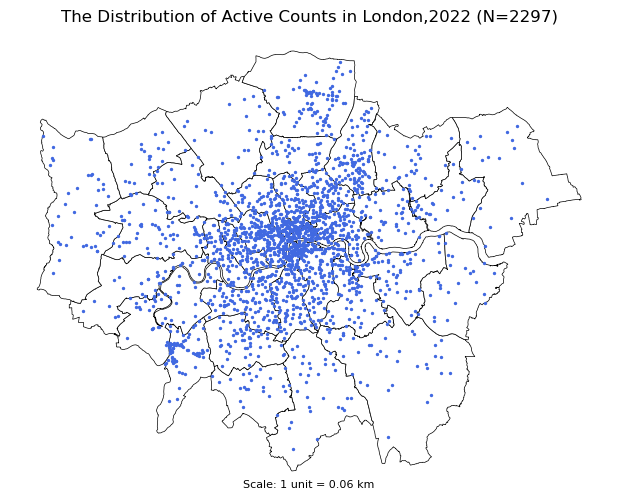

In [121]:
# mapping 

# create a GeoDataFrame with the active counts (point data)
points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(travel_counts_df['Easting (UK Grid)'], travel_counts_df['Northing (UK Grid)']))
# map london borough 
ax=boros.plot(edgecolor='black', facecolor='white', linewidth=0.5, figsize=(8,6),legend=True)
# map the active counts
points_gdf.plot(marker='o', color='royalblue', markersize=2, ax=ax,label='Point Data')

# The line ax = plt.gca() is used to get the current Axes instance in Matplotlib. 
# The gca stands for "get current axes." It retrieves the Axes (the subplot, the area where you can plot your data) that is currently being used or created in the current figure.
# ax = ax simply assigns the existing Axes instance to the variable ax. 

# increase the elements of map

# Title
plt.title('The Distribution of Active Counts in London,2022 (N=2297)')

# scaler
# calculate the geographic distance
latitude1, longitude1 = travel_counts_df.iloc[0]['Latitude'], travel_counts_df.iloc[0]['Longitude']
latitude2, longitude2 = travel_counts_df.iloc[1]['Latitude'], travel_counts_df.iloc[1]['Longitude']

distance_km = geodesic((latitude1, longitude1), (latitude2, longitude2)).kilometers

print(f"The distance between the two points is {distance_km:.2f} kilometers.")

# calculate the map distance in the two points
line_segment = Line2D([latitude1, longitude1], [latitude2, longitude2], linestyle='-', marker='o', markersize=8,)
line_data = line_segment.get_xydata()
# calculate the x-cooridnate and x-cooridnate difference between two points 
# calculate the Euclidean distance between two points
scale_value = ((line_data[1, 0] - line_data[0, 0])**2 + (line_data[1, 1] - line_data[0, 1])**2)**0.5
print(f"The length of the line segment is {scale_value:.2f} units.")

scale_bar_length_km = distance_km/scale_value  # calculate the scale
scale_bar_location = (0.5, 0.009)  # set the location of scale bar

ax.set_axis_off()
ax.annotate(f'Scale: 1 unit = {scale_bar_length_km:.2f} km', xy=scale_bar_location, xycoords='axes fraction', ha='center', fontsize=8)

# mapping 
plt.show()


In [95]:
# Descriptive Analysis
# firstly check the total number of the dependent variable

number_of_rows_df = len(cycles_counts_df)
print(f"The DataFrame has {number_of_rows_df} rows.")

The DataFrame has 552896 rows.


In [96]:
# the max and min of the dependent variable
max= cycles_counts_df['Count'].max()
min= cycles_counts_df['Count'].min()
print(f"The maximun value of count are {max}")
print(f"The minmun value of count are {min}")

# the mean and standard deviation of the dependent variable
cycles_counts_df_mean = cycles_counts_df['Count'].mean().round(3)
cycles_counts_df_std =cycles_counts_df['Count'].std()
cycles_counts_df_std_3 = round(cycles_counts_df_std,3)

print(f"The mean and standard deviation of count are {cycles_counts_df_mean}+{cycles_counts_df_std_3}")

The maximun value of count are 562
The minmun value of count are 0
The mean and standard deviation of count are 3.066+12.268


In [103]:
percentile_values25 = cycles_counts_df['Count'].quantile(25/ 100)
percentile_values50 = cycles_counts_df['Count'].quantile(50/ 100)
percentile_values75 = cycles_counts_df['Count'].quantile(75/ 100)
print(percentile_values25)
print(percentile_values50)
print(percentile_values75)

0.0
0.0
1.0


562
0


<Axes: >

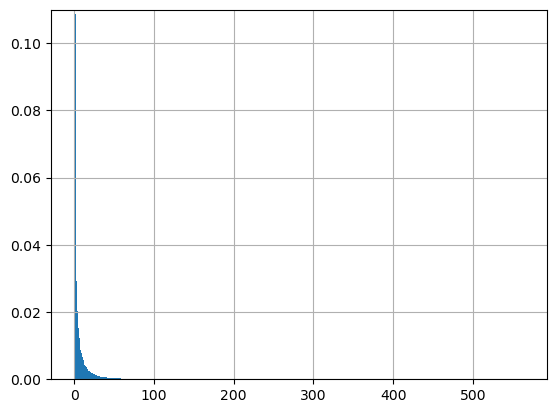

In [32]:
# check distribution: result:skewed distribution
max= cycles_counts_df['Count'].max()
min= cycles_counts_df['Count'].min()
print(max)
print(min)

hist_min=int(min)-1
hist_max=int(max)+2
x_range=[hist_min,hist_max]
y_range = [0,0.11]
n_cols = hist_max - hist_min

plt.figure(1)
plt.ylim(y_range)
cycles_counts_df['Count'].hist(range=x_range, bins=n_cols, density=True)

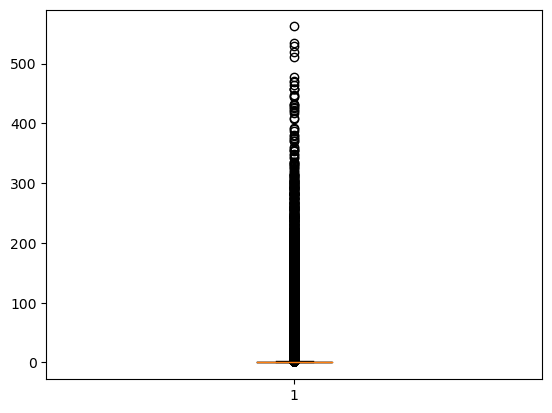

In [104]:
# find the outliter 
plt.boxplot(cycles_counts_df['Count'])
plt.show()

In [120]:
q1=cycles_counts_df['Count'].quantile(0.25)
q3=cycles_counts_df['Count'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = cycles_counts_df[(cycles_counts_df['Count'] < lower_bound) | (cycles_counts_df['Count'] > upper_bound)]
outliers.sample(5)

,Year,UnqID,Zone,datetime,Date,Weather,Time,Day,Round,Dir,Path,Mode,Count,isdry,ispeak,isCarriageway,isPavement,isCycle,isBus,isShared
75415,2022,CSHCY063,1,2022-07-19 11:45:00,19/07/2022,Dry,11:45:00,Weekday,A,Northbound,Cycle lane,Conventional cycles,8,1,0,0,0,1,0,0
241276,2022,INNCY132,1,2022-07-20 21:00:00,20/07/2022,Dry,21:00:00,Weekday,A,Northbound,Carriageway,Conventional cycles,22,1,0,1,0,0,0,0
217707,2022,QWPCY090,1,2022-06-13 16:45:00,13/06/2022,Dry,16:45:00,Weekday,A,Southbound,Carriageway,Conventional cycles,8,1,1,1,0,0,0,0
33641,2022,CENCY015,0,2022-07-06 16:15:00,06/07/2022,Dry,16:15:00,Weekday,A,Southbound,Bus lane,Conventional cycles,85,1,1,0,0,0,1,0
233047,2022,CENCY121,0,2022-06-08 11:45:00,08/06/2022,Dry,11:45:00,Weekday,A,Northbound,Cycle lane,Conventional cycles,8,1,0,0,0,1,0,0


In [93]:
# normal distribution: log change
import numpy as np
cycles_counts_df['Count_log'] = np.log1p(cycles_counts_df['Count'])cycles_counts_df['Count'].

/tmp/ipykernel_5285/3130011033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cycles_counts_df['Count_log'] = np.log1p(cycles_counts_df['Count'])


6.333279628139691
0.0


(0.0, 0.9)

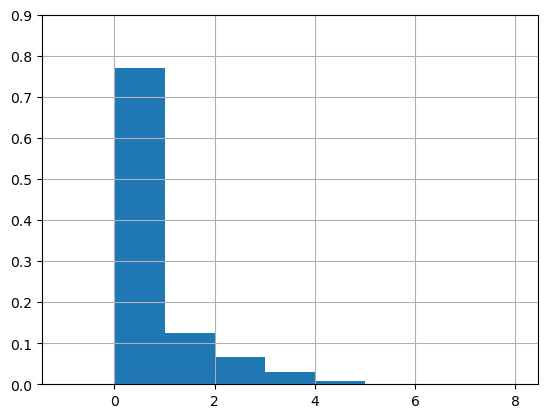

In [94]:
# distribution: result:skewed distribution
max_normal= cycles_counts_df['Count_log'].max()
min_normal= cycles_counts_df['Count_log'].min()
print(max_normal)
print(min_normal)

hist_min_normal=int(min_normal)-1
hist_max_normal=int(max_normal)+2
x_range_normal=[hist_min_normal,hist_max_normal]
y_range_normal = [0,0.9]
n_cols_normal = hist_max_normal - hist_min_normal

plt.figure(2)
cycles_counts_df['Count_log'].hist(range=x_range_normal,bins=n_cols_normal, density=True)
plt.ylim(y_range_normal)